In [254]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum

# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [255]:
N = 1
M = 30
minValue = 0
maxValue = 5
beta_1 = 0.9
beta_2 = 0.999
batch = random.randint(1, M)

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

a = np.array([1, 2])
print(np.sqrt(a))

[1.         1.41421356]


In [256]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + 0.5 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)


def runSGD(batch, typeOfOptimisation, withNormalization, lr, eps):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm, \
        errors_norm, \
        YF_norm, \
        iterations = gradient_descent(batch,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      TypeOfOptimisation.none,
                                      with_normalization=True)
        print("batch:                   ", batch)
        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        print()
        drawGraph(X_norm, Y_norm, YF_norm, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors_norm, iterations, batch, withNormalization, typeOfOptimisation)
    else:
        B_final, \
        errors, \
        YF, \
        iterations = gradient_descent(batch,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      typeOfOptimisation,
                                      with_normalization=False)
        print("batch:                   ", batch)
        print(errors[0], errors[len(errors) - 1])
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        print()
        drawGraph(XM, YM, YF, batch, withNormalization, typeOfOptimisation)
        draw_errors_graphic(errors, iterations, batch, withNormalization, typeOfOptimisation)


[-3. -3.]


batch:                    1
21.073 2.0053654185669063
actual coefficients:      [-3. -3.]
calculated coefficients:  [-0.13606507 -3.09132697]
number of iterations:     6

batch:                    15.0
178.08840000000004 3.067524054191829e+23
actual coefficients:      [-3. -3.]
calculated coefficients:  [1.03867100e+21 2.10837058e+22]
number of iterations:     40

batch:                    30
344.47406666666666 5.843519509307083e+22
actual coefficients:      [-3. -3.]
calculated coefficients:  [2.04387017e+20 4.01591780e+21]
number of iterations:     24



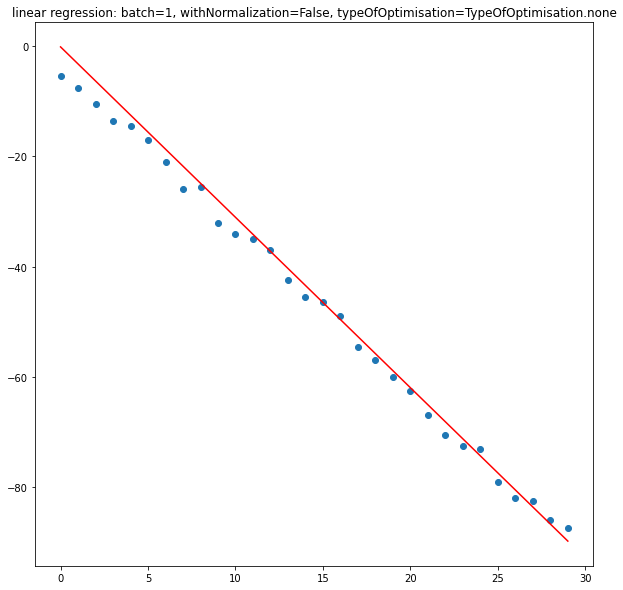

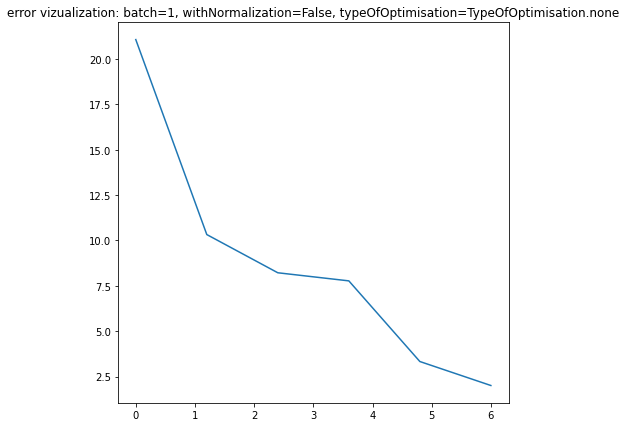

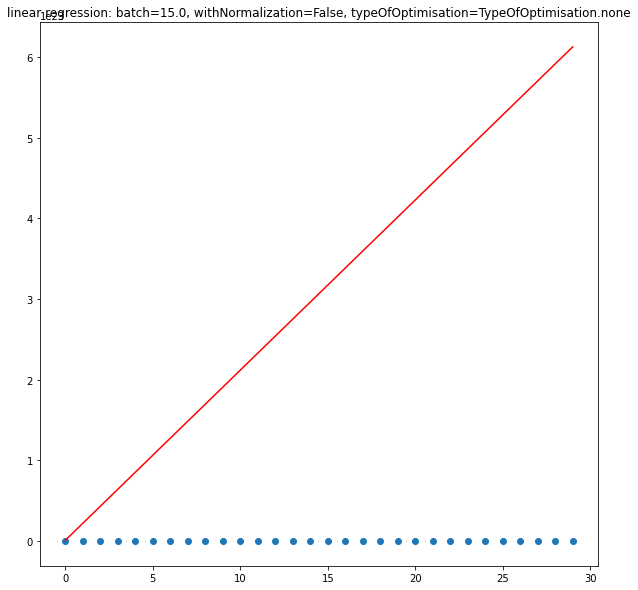

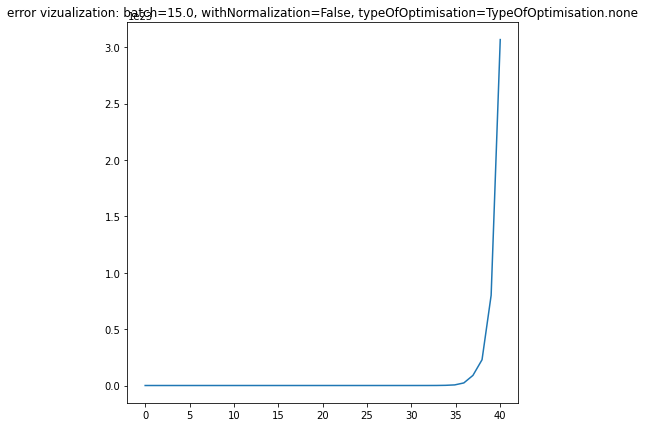

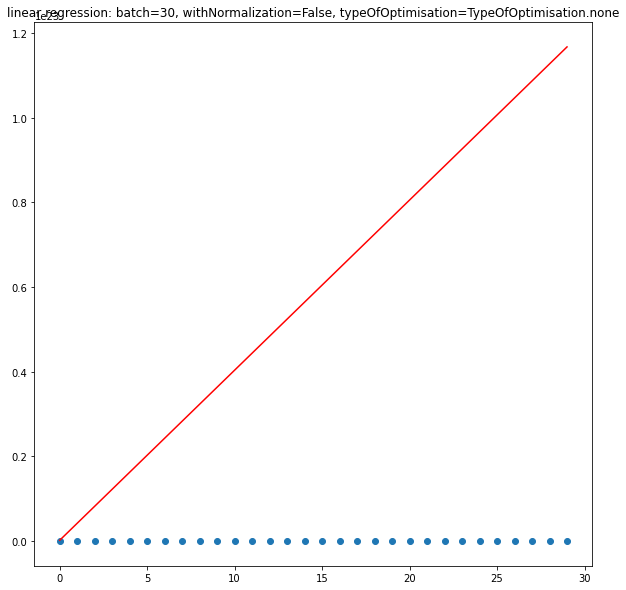

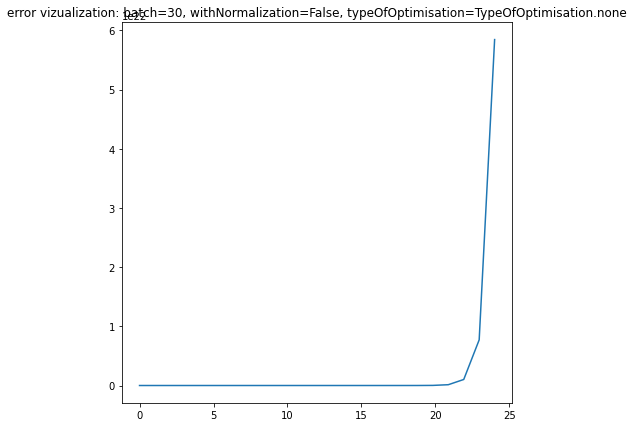

In [257]:
def mean_error(Y_act, Y_reg):
    return np.sum(abs(Y_act - Y_reg)) / M


def stopping_criteria(previous, current, eps):
    return abs(previous - current) < eps


def gradient(nums, XM, YR, YM):
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        grad.append(xi)
    return np.array(grad)


def gradient_descent(batch, XM, YM, YR, B_reg, lr, eps, type_of_optimisation, with_normalization):
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - lr * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = previous_gradient + np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gamma * previous_gradient + (1 - gamma) * np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
        B_reg -= lr * grad

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if stopping_criteria(previous_error, mean_error(YM, YR), eps):
            break
        previous_error = mean_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    return B_reg, errors, YR, iterations


def drawGraph(XM, YM, YF, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, withNormalization, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    title = 'error vizualization: batch=' + str(batch) + \
            ', withNormalization=' + str(withNormalization) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


runSGD(1, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
runSGD(M / 2, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)
runSGD(M, TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)

# Задание 2

batch:                    1
0.8563500921788251 0.04167251585161006
actual coefficients:      [nan nan]
calculated coefficients:  [-0.00563086 -0.99005132]
number of iterations:     472

batch:                    15.0
0.7581686811713106 0.044477976296357725
actual coefficients:      [nan nan]
calculated coefficients:  [ 0.00692761 -0.99894818]
number of iterations:     211

batch:                    30
0.6090423659626152 0.04352768204975548
actual coefficients:      [nan nan]
calculated coefficients:  [-1.22679644e-16 -9.98749650e-01]
number of iterations:     30



/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


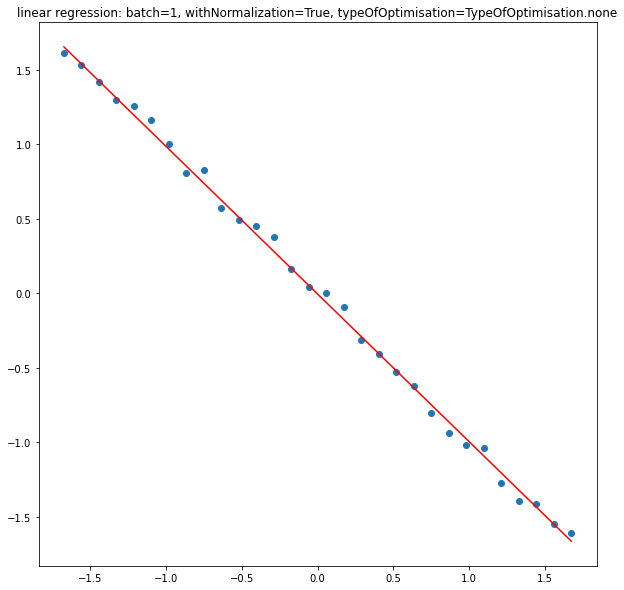

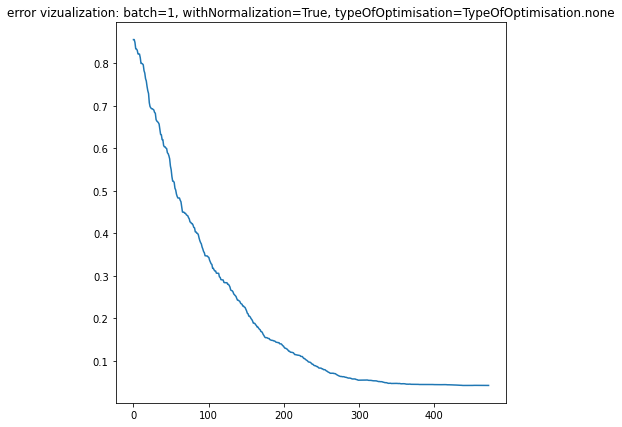

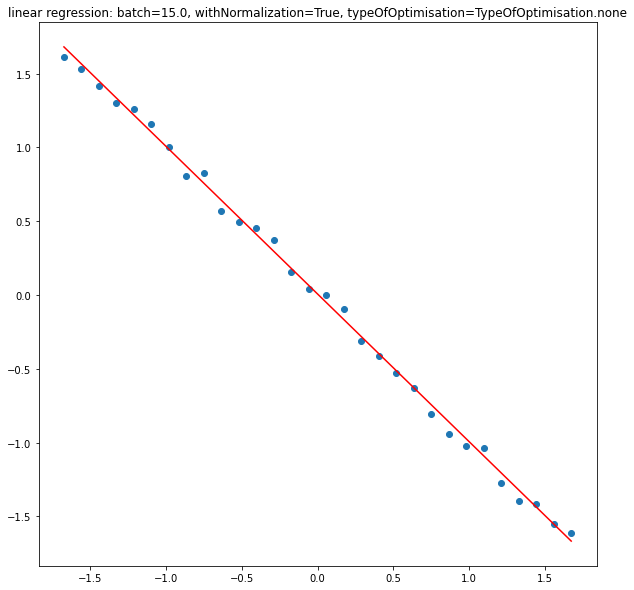

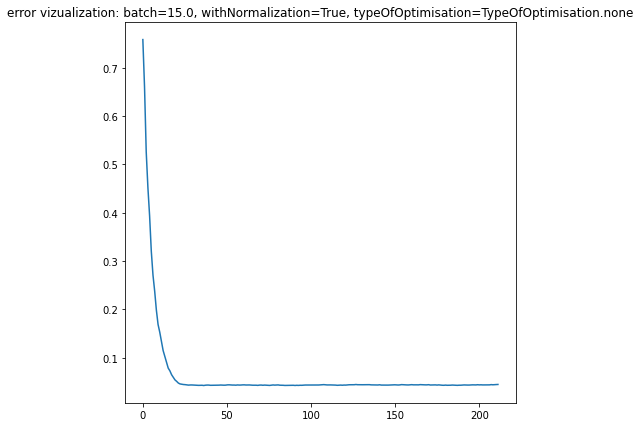

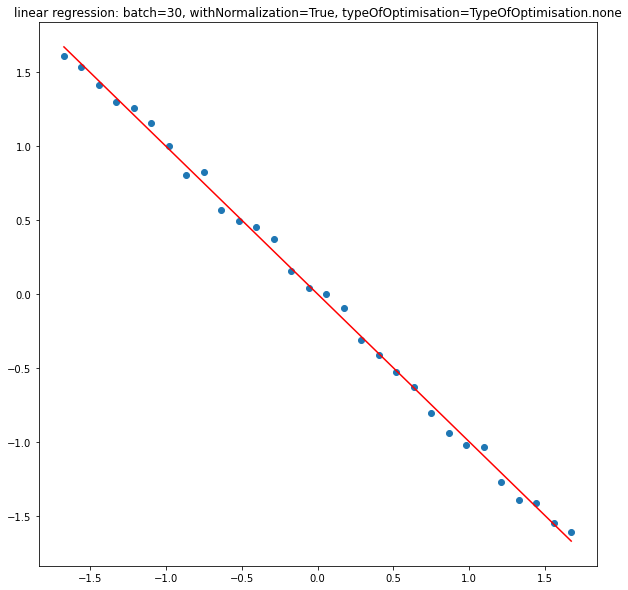

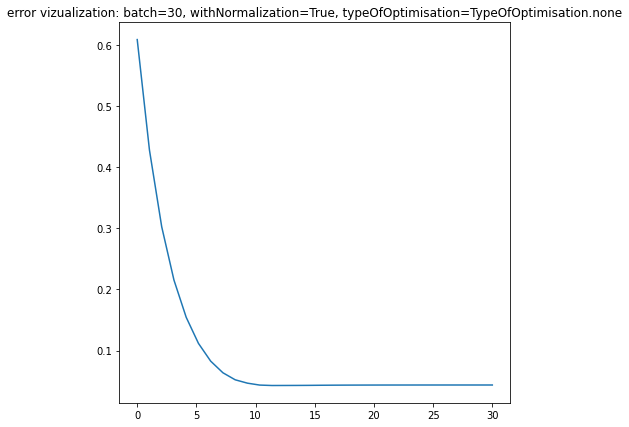

In [258]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
runSGD(1, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)
runSGD(M, TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.

batch:                    1
41.65 1.0874037916361232
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.60288926 -24.97422903]
number of iterations:     1132

batch:                    15.0
13.212754912866153 1.287377300552128
actual coefficients:      [-3. -3.]
calculated coefficients:  [-45.91275588 -25.83858765]
number of iterations:     6476

batch:                    30
93.1 1.1081124681850025
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.55221858 -25.42933917]
number of iterations:     187

batch:                    1
0.7063710531003411 0.04139817161411732
actual coefficients:      [nan nan]
calculated coefficients:  [-0.01008571 -0.99213986]
number of iterations:     142

batch:                    15.0
0.2330615805134179 0.04601107317212153
actual coefficients:      [nan nan]
calculated coefficients:  [ 0.01204825 -1.00563622]
number of iterations:     1486

batch:                    30
1.7289227754550298 1.046249313036311e+24
actual coeffici

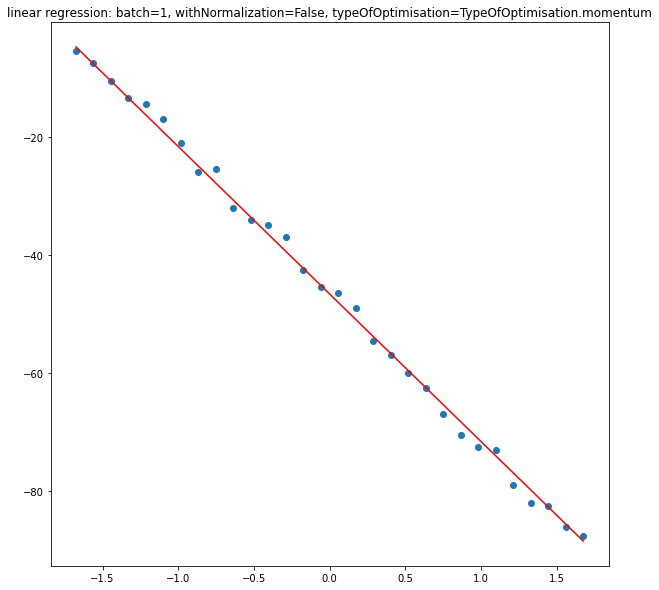

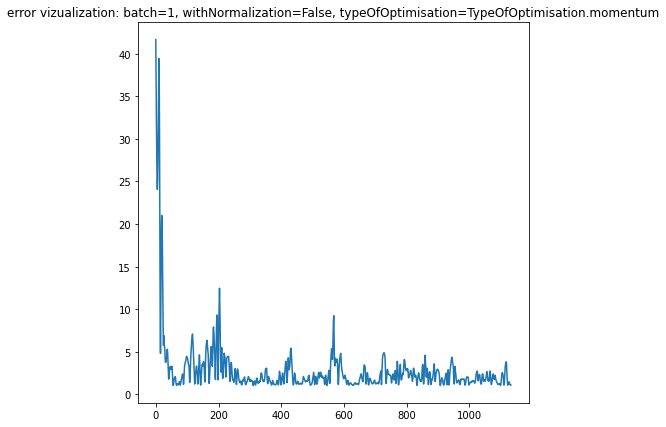

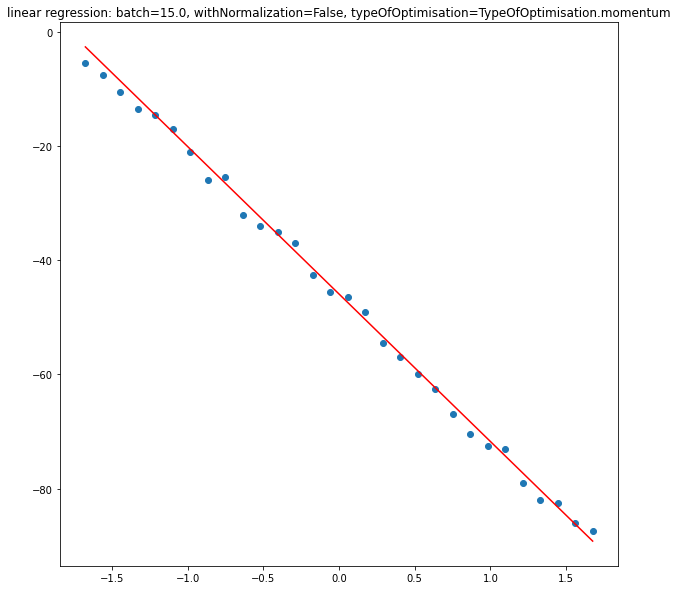

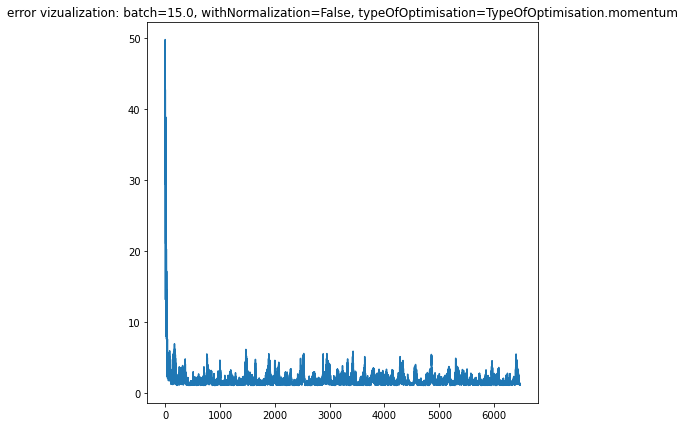

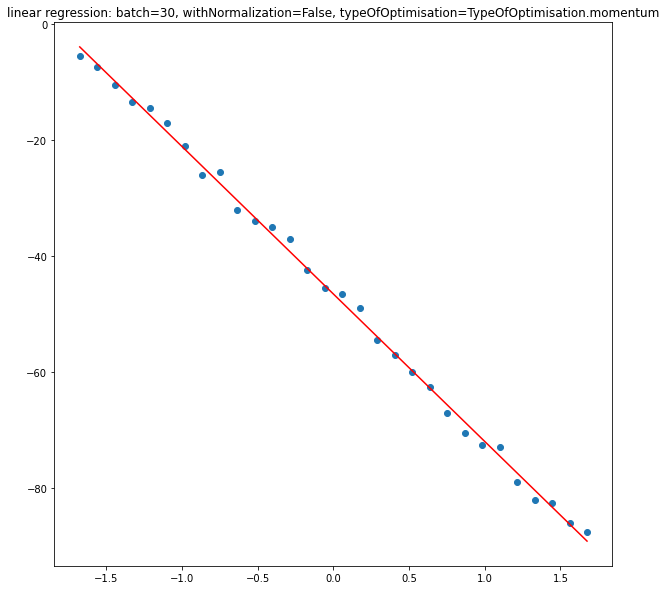

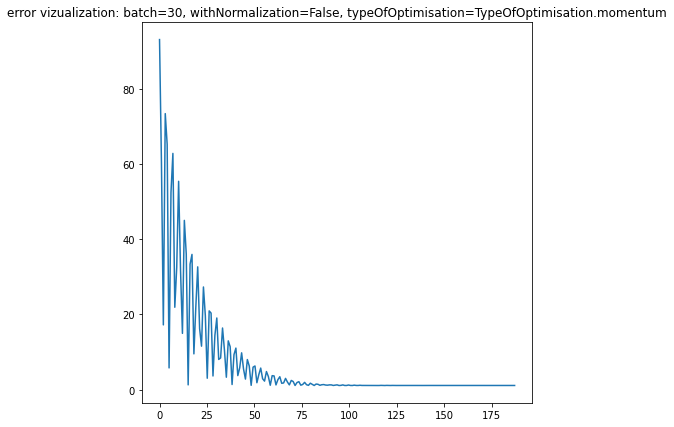

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


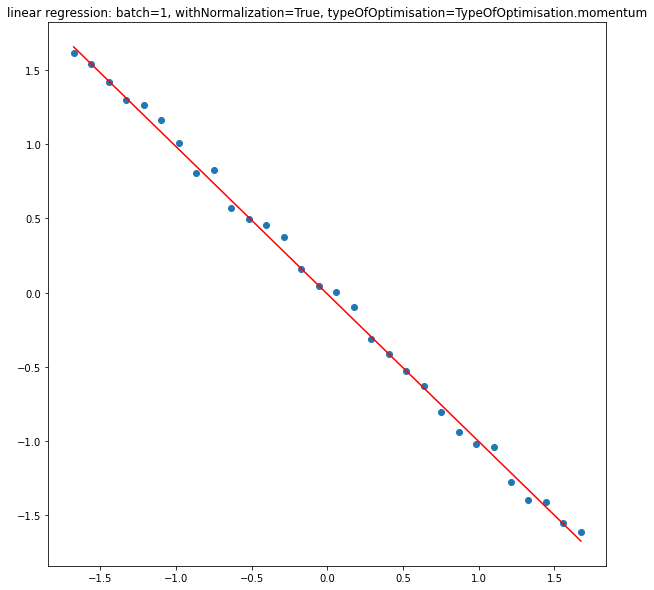

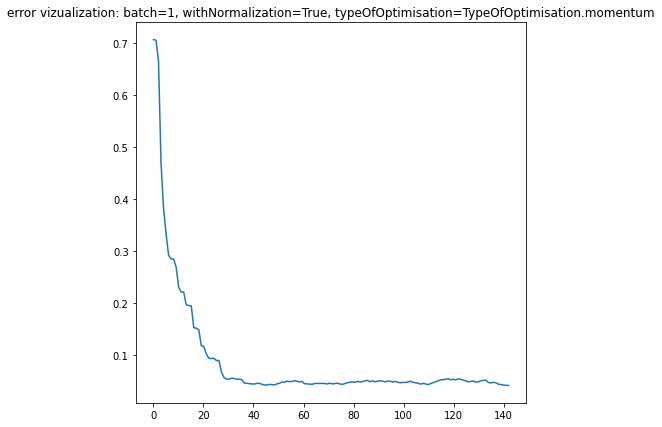

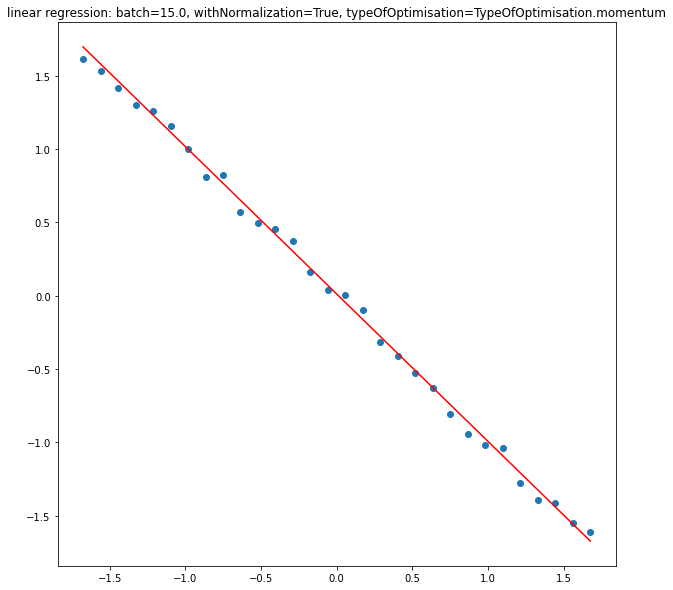

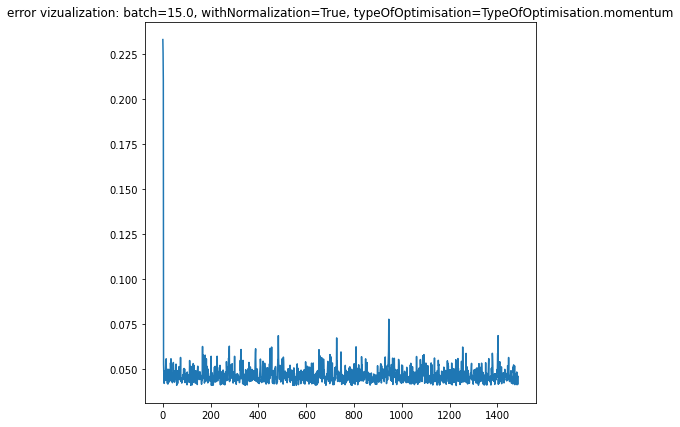

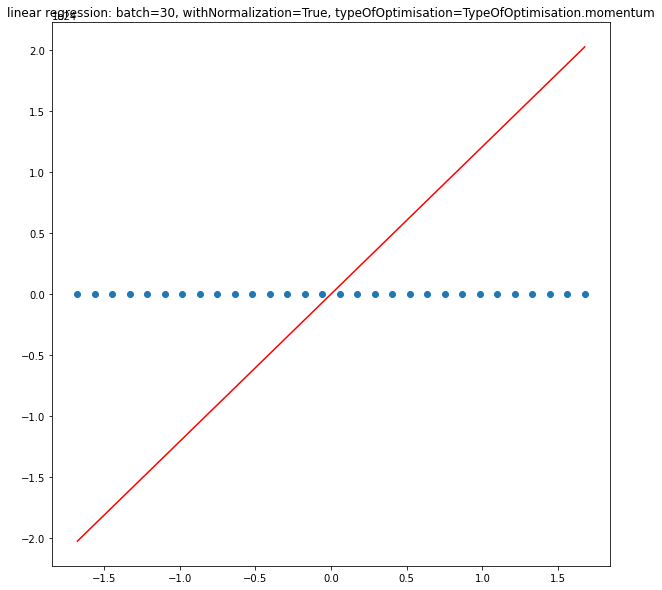

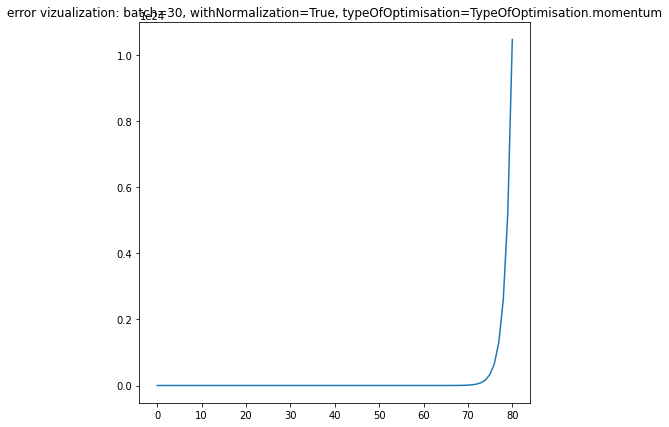

In [259]:
gamma = 0.9

runSGD(1, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M, TypeOfOptimisation.momentum, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(1, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M, TypeOfOptimisation.momentum, withNormalization=True, lr=1e-1, eps=1e-6)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.

batch:                    1
41.1 1.3052861001264764
actual coefficients:      [-3. -3.]
calculated coefficients:  [-45.87244599 -25.87752948]
number of iterations:     1040

batch:                    15.0
22.10000000000001 5.840466230944114e+24
actual coefficients:      [-3. -3.]
calculated coefficients:  [5.84046623e+24 2.83057960e+24]
number of iterations:     457

batch:                    30
93.1 6.961865021110942e+24
actual coefficients:      [-3. -3.]
calculated coefficients:  [6.96186502e+24 3.80294715e+24]
number of iterations:     354

batch:                    1
0.8096851243625057 0.04507749185278036
actual coefficients:      [nan nan]
calculated coefficients:  [-0.01571352 -0.9733469 ]
number of iterations:     41

batch:                    15.0
0.31539727967999165 0.044347273875965716
actual coefficients:      [nan nan]
calculated coefficients:  [ 0.00703691 -0.99691515]
number of iterations:     3216

batch:                    30
1.7289227754550298 1.0462493130363082e+24
a

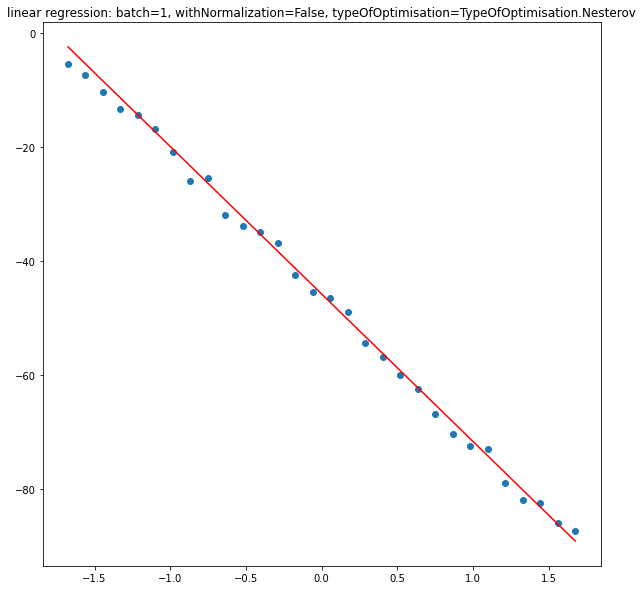

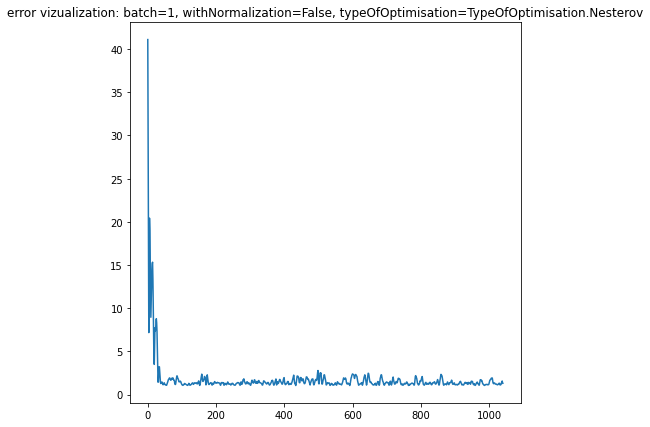

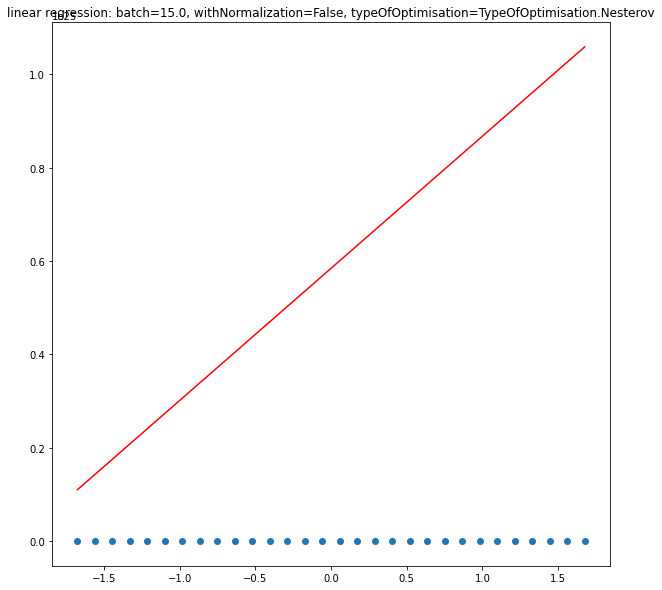

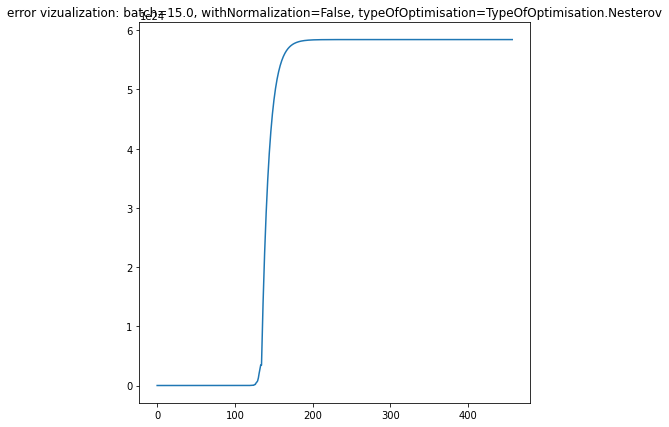

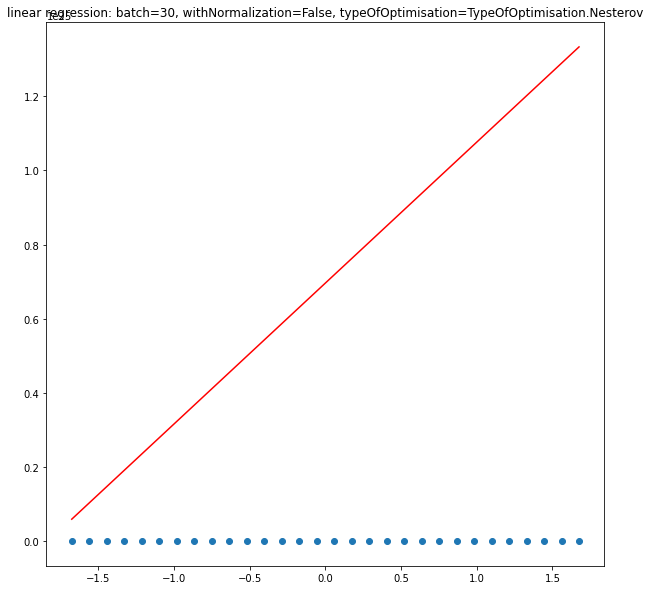

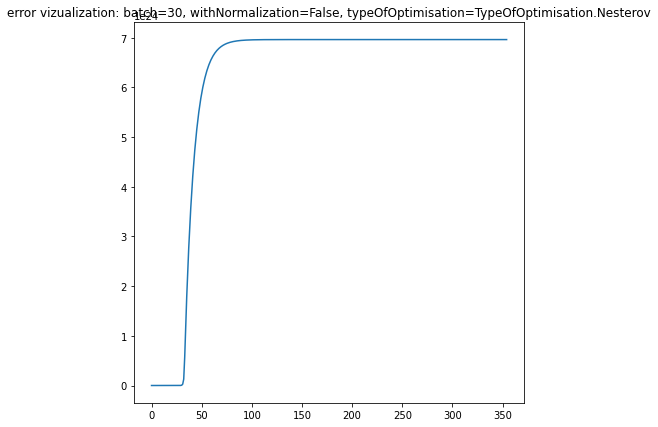

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


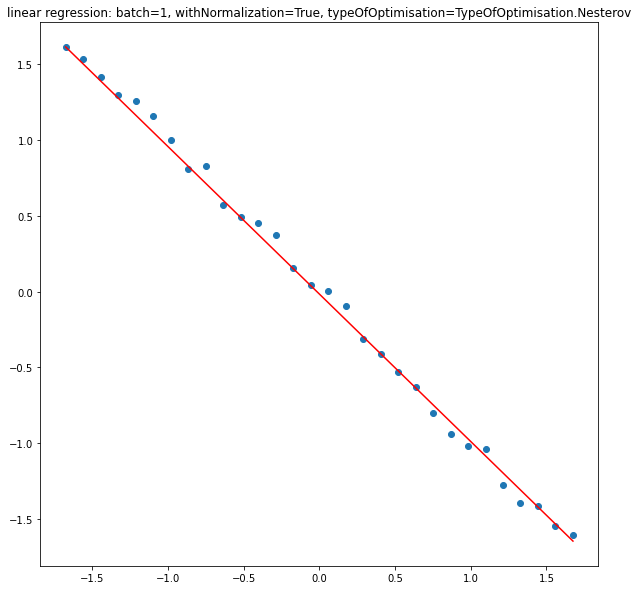

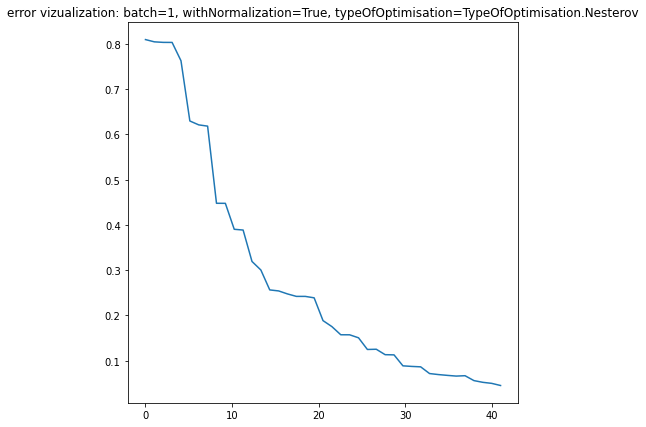

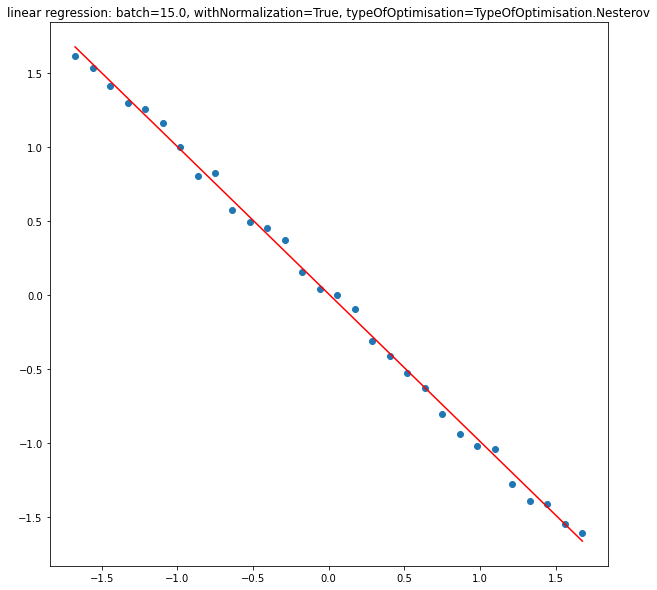

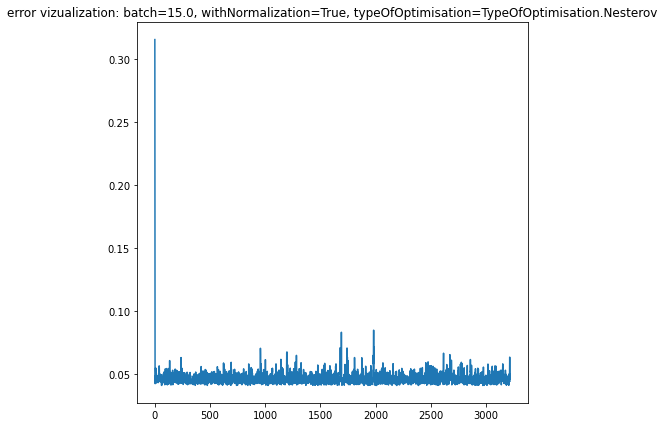

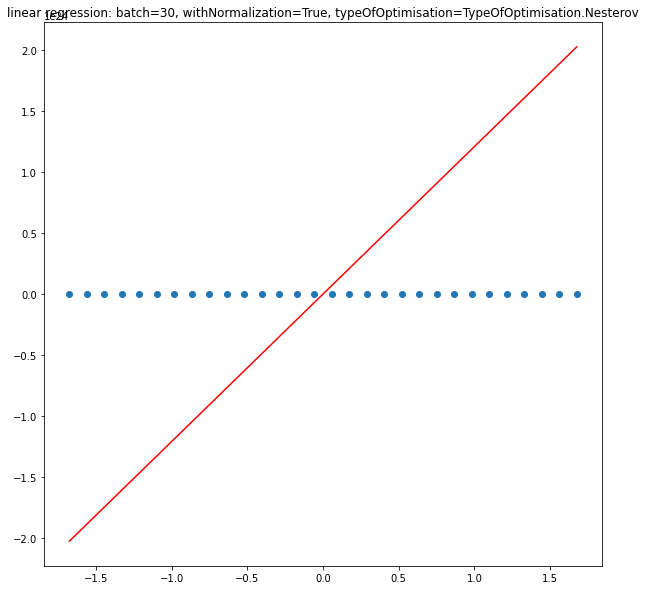

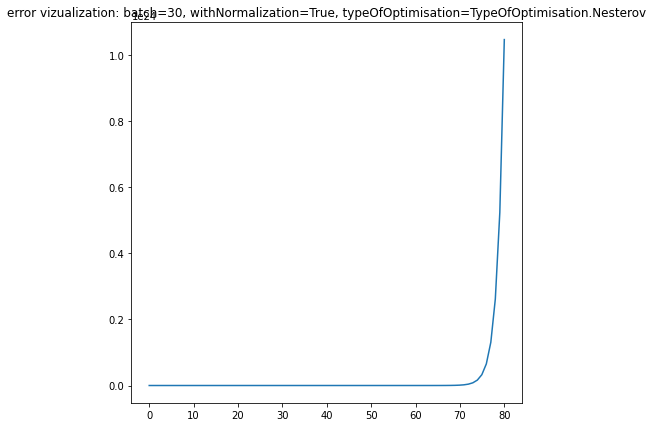

In [260]:
runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(1, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M, TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-1, eps=1e-6)

### AdaGrad

batch:                    1
46.45000000408163 2.834215982457878
actual coefficients:      [-3. -3.]
calculated coefficients:  [-44.29076961 -23.01585969]
number of iterations:     683

batch:                    15.0
46.45000000001322 1.1027578184527904
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.55287778 -25.38748259]
number of iterations:     486

batch:                    30
46.45000000000256 1.1082892916344909
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.54681215 -25.42443528]
number of iterations:     640

batch:                    1
0.8208384679487178 0.04211346458766074
actual coefficients:      [nan nan]
calculated coefficients:  [-0.01386746 -0.99669026]
number of iterations:     94

batch:                    15.0
0.3957256222517475 0.04534808671831821
actual coefficients:      [nan nan]
calculated coefficients:  [-0.01951561 -1.01196169]
number of iterations:     10059

batch:                    30
1.7289227754550298 1.0462493130363

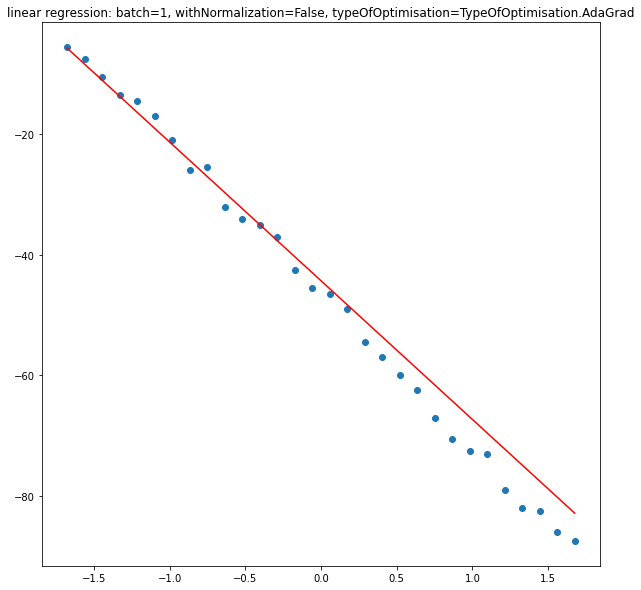

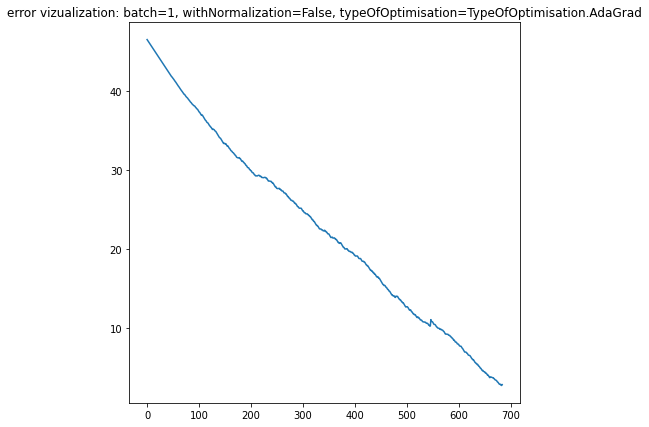

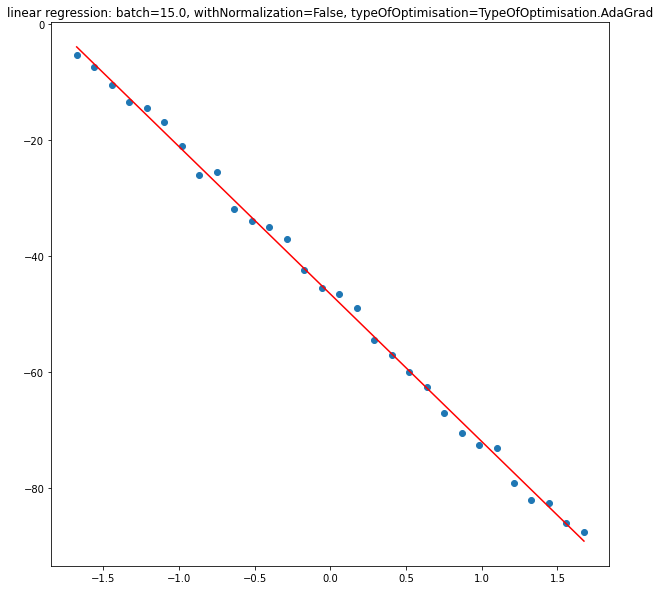

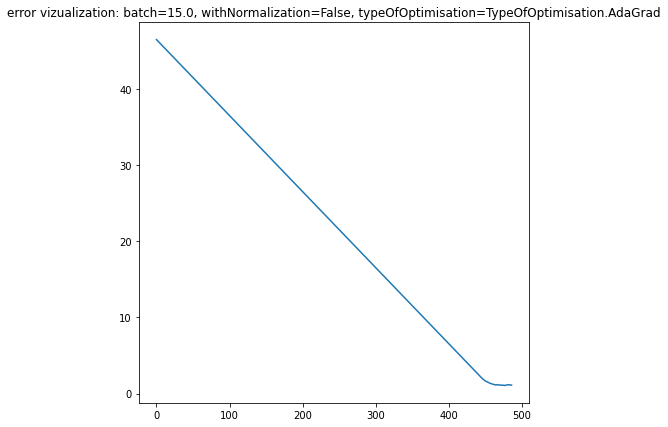

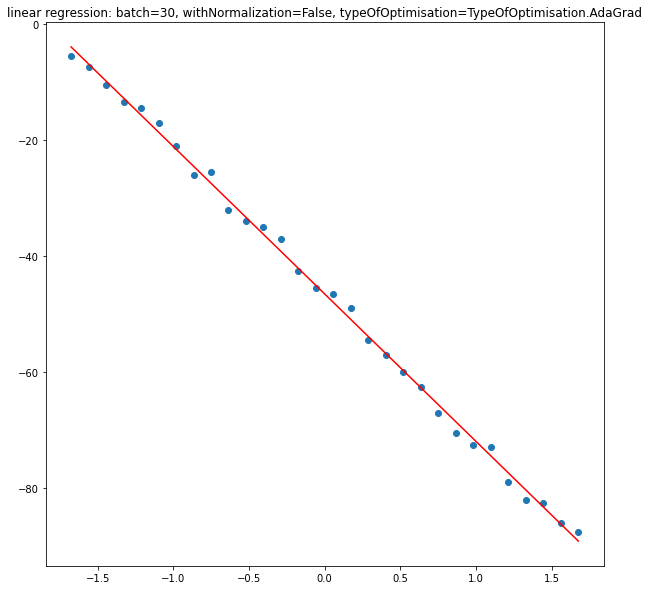

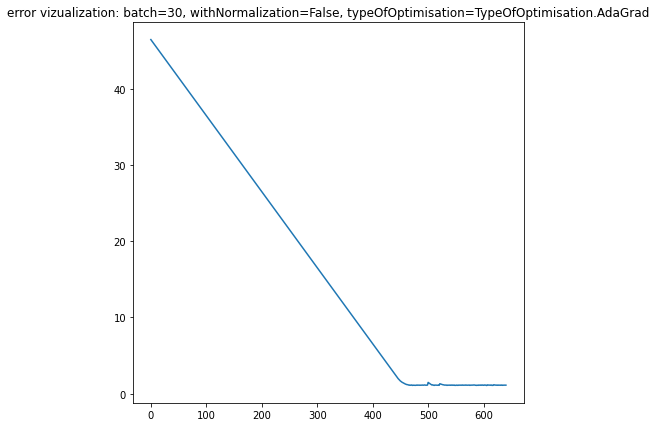

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


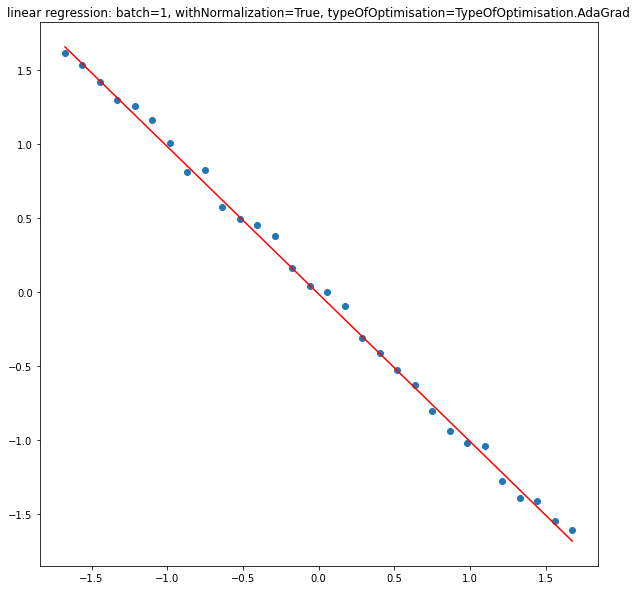

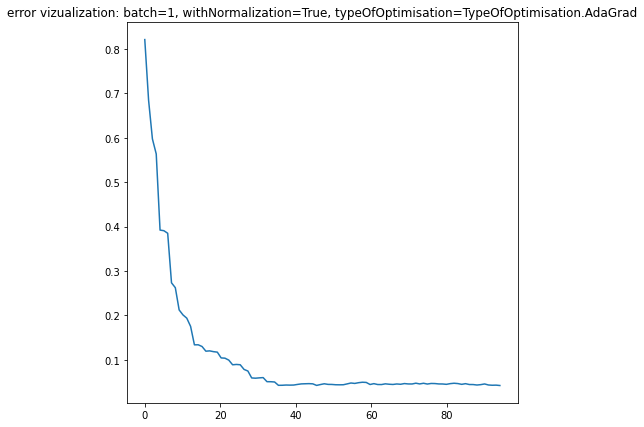

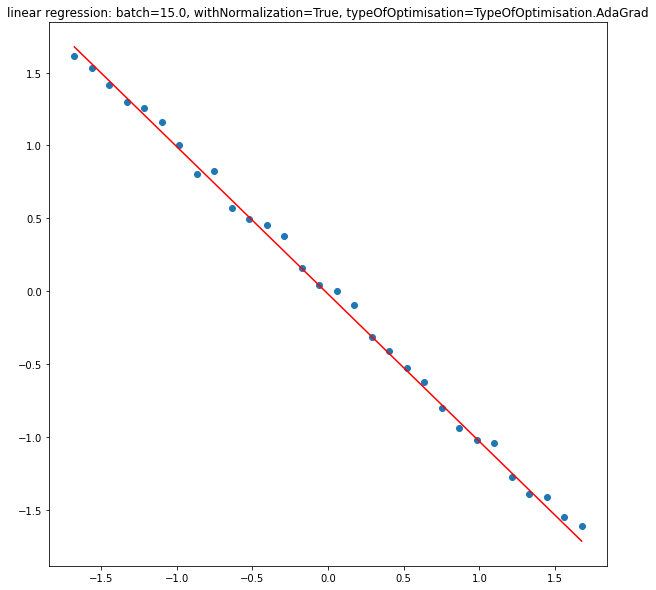

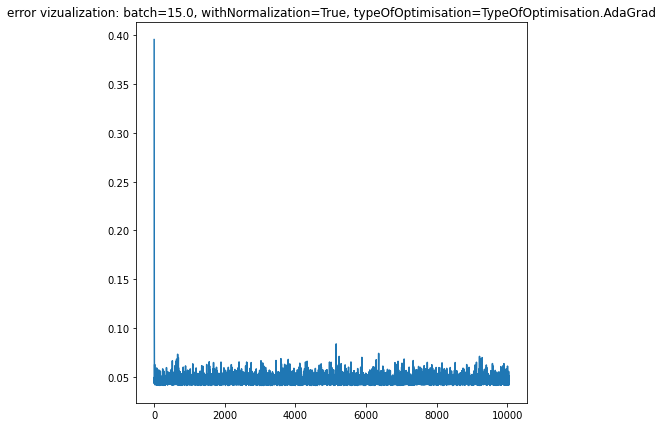

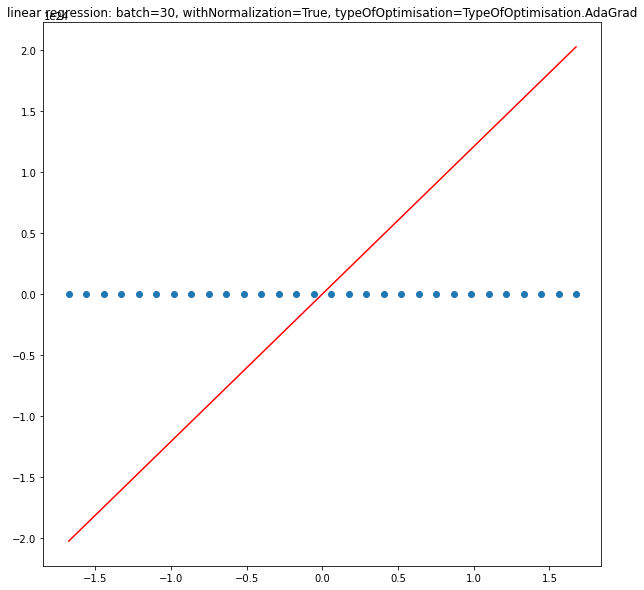

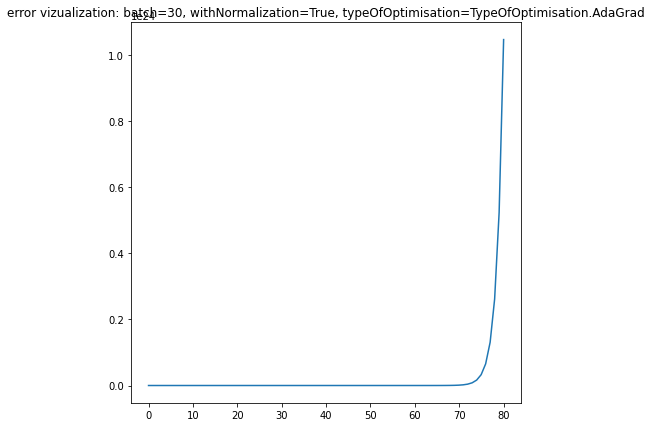

In [261]:
runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(1, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M, TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-1, eps=1e-6)

### RMSProp

without normalization: 
batch:                    1
46.23377225536146 8.525518454058206
actual coefficients:      [-3. -3.]
calculated coefficients:  [-38.90308701 -18.24131555]
number of iterations:     197

batch:                    15.0
46.23377223424778 1.1270598306401136
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.3964981  -25.41465609]
number of iterations:     1976

batch:                    30
46.233772234064226 1.1095372801829204
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.46292037 -25.33768696]
number of iterations:     246

with normaliztion: 
batch:                    1
0.8518384768943738 0.04133473988069458
actual coefficients:      [nan nan]
calculated coefficients:  [-0.01046898 -0.99189487]
number of iterations:     75

batch:                    15.0
0.43942591833528993 0.04831784782290729
actual coefficients:      [nan nan]
calculated coefficients:  [-0.03105006 -1.01321035]
number of iterations:     8133

batch:           

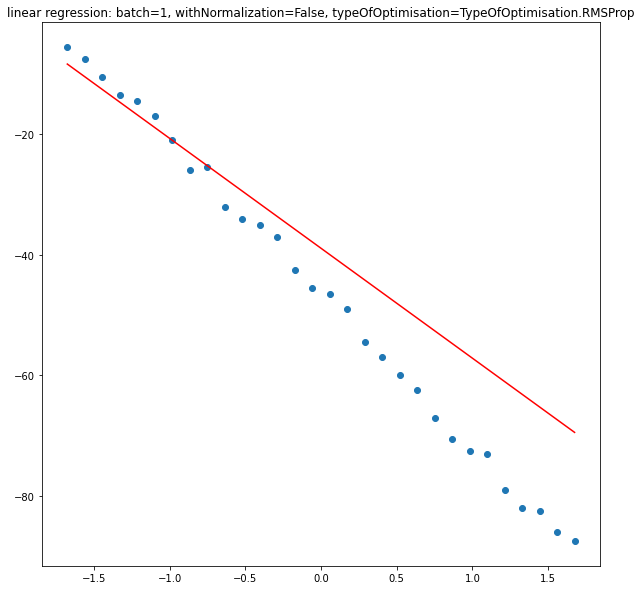

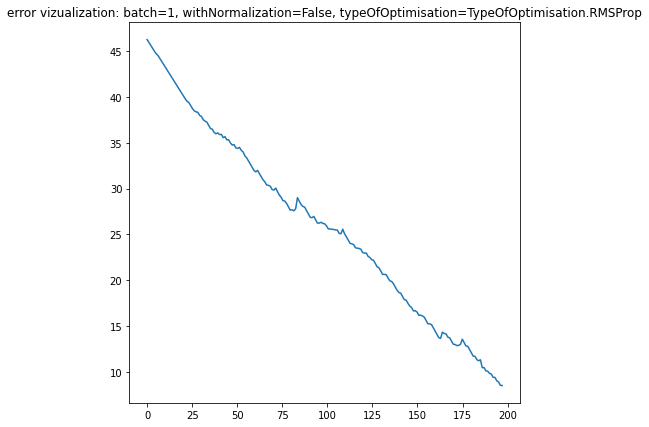

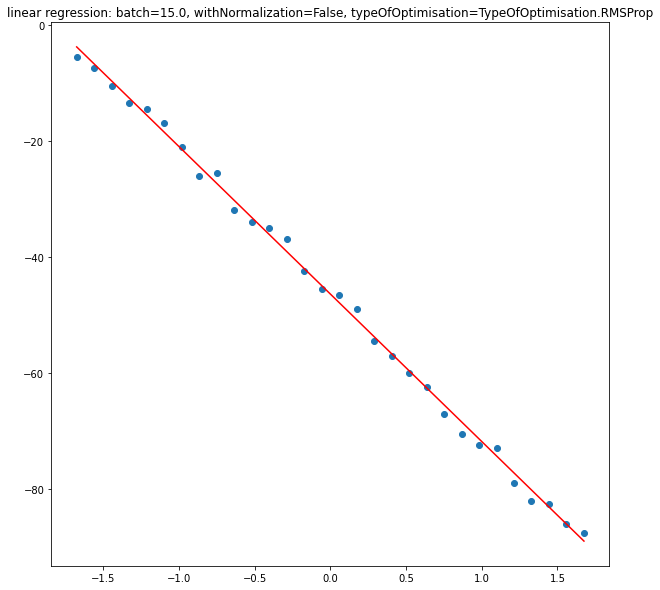

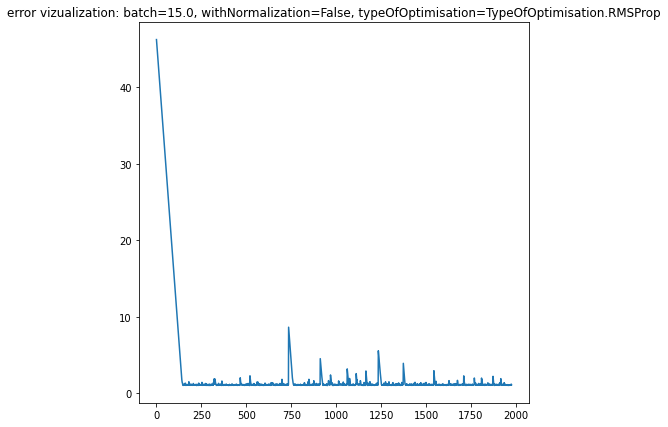

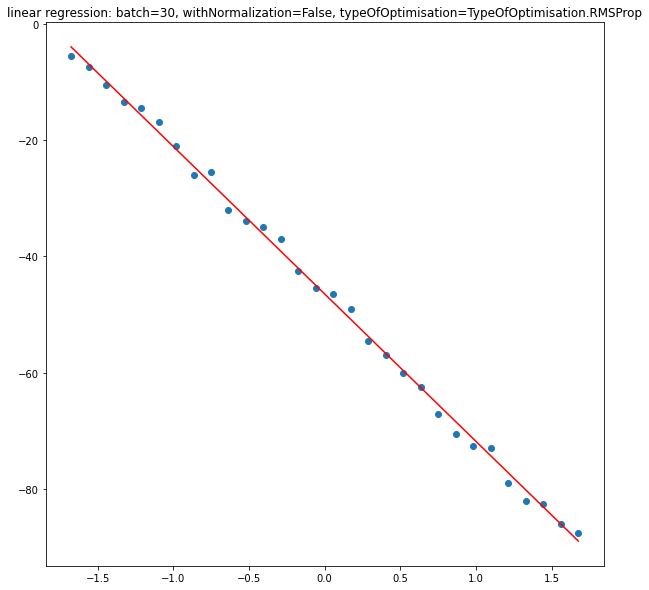

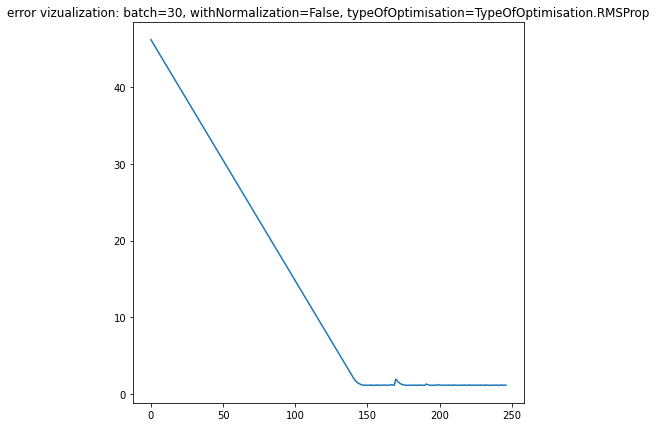

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


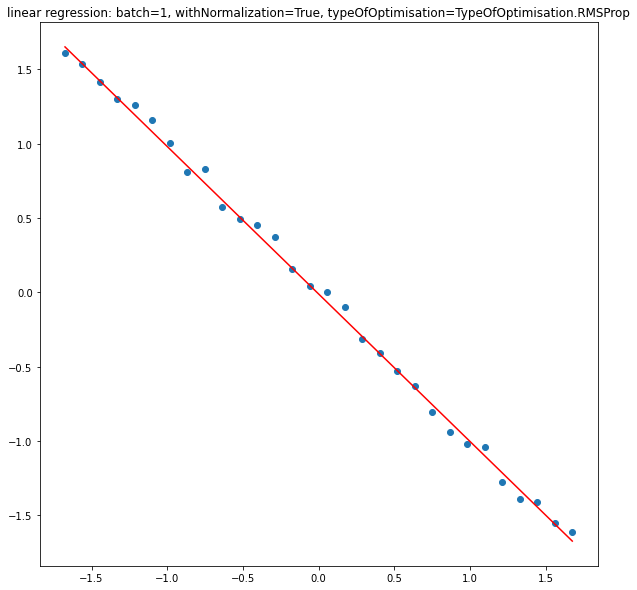

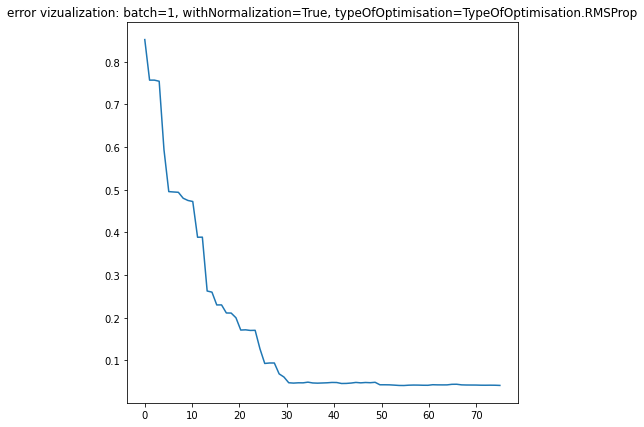

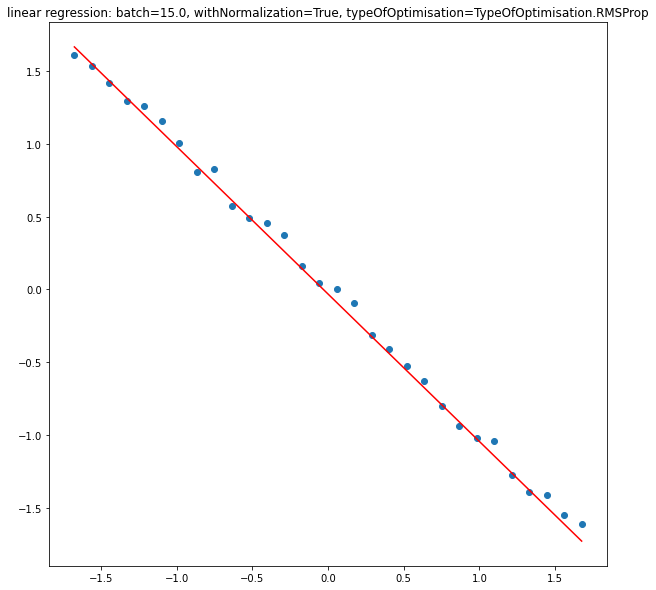

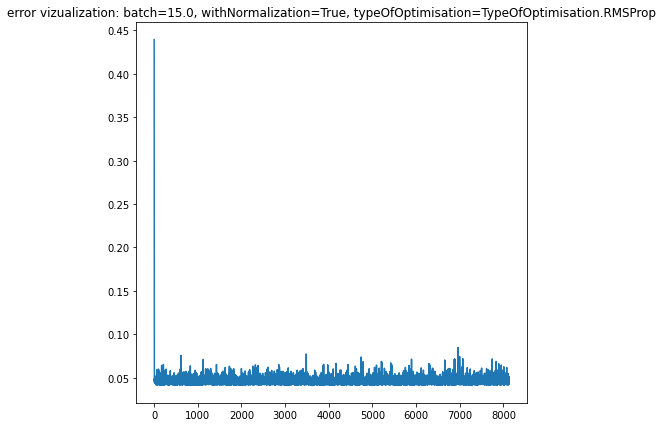

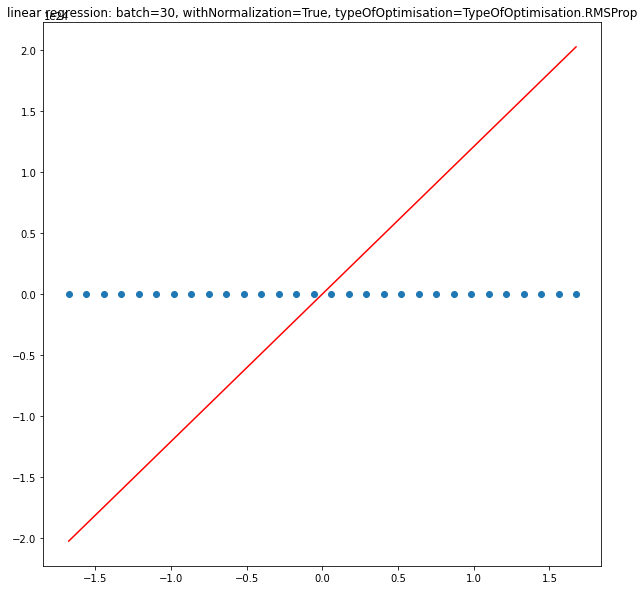

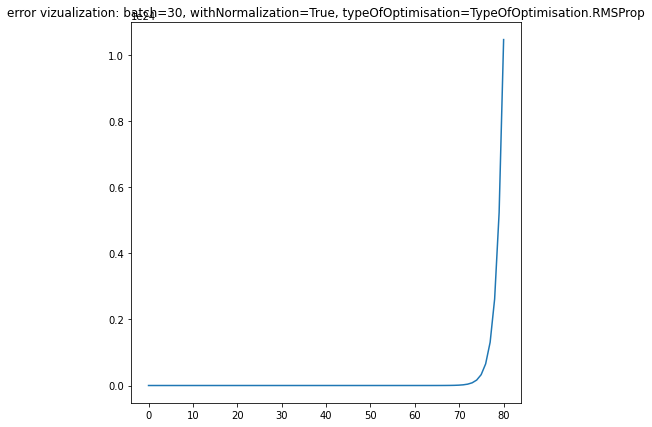

In [262]:
print("without normalization: ")
runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-1, eps=1e-4)
print("with normaliztion: ")
runSGD(1, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M, TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-1, eps=1e-6)


### Adam

without normalization: 
batch:                    1
46.4500000237812 1.1523878666519518
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.29926776 -25.1644444 ]
number of iterations:     2196

batch:                    15.0
46.4500000000111 1.1374732627416522
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.33680137 -25.41961266]
number of iterations:     1964

batch:                    30
46.45000000000256 1.133072485182393
actual coefficients:      [-3. -3.]
calculated coefficients:  [-46.36471856 -25.42812648]
number of iterations:     2018

with normaliztion: 
batch:                    1
0.8096851243625057 0.042781775213745564
actual coefficients:      [nan nan]
calculated coefficients:  [-0.00744438 -0.99998024]
number of iterations:     367

batch:                    15.0
0.32292737912824415 0.04650581576070355
actual coefficients:      [nan nan]
calculated coefficients:  [-0.00985989 -1.0200479 ]
number of iterations:     3790

batch:          

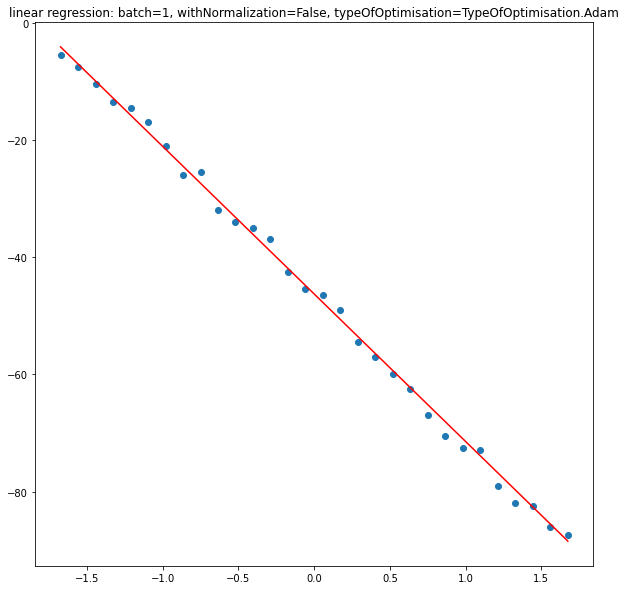

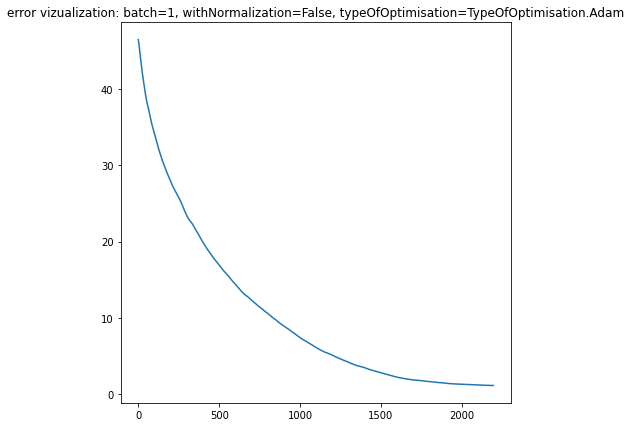

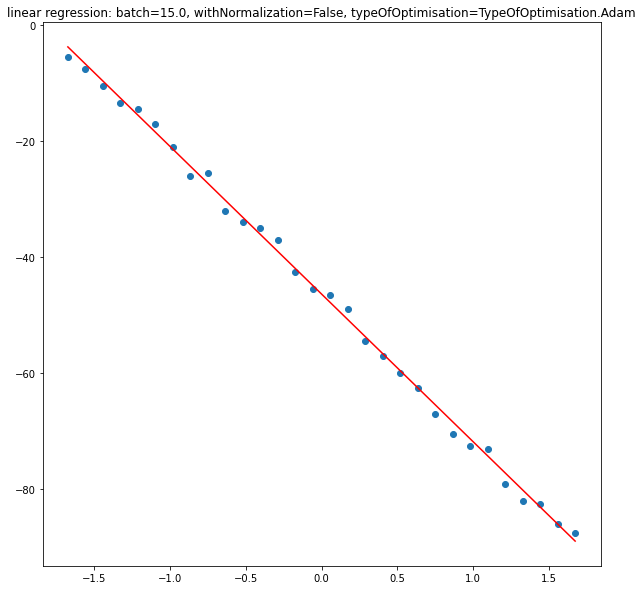

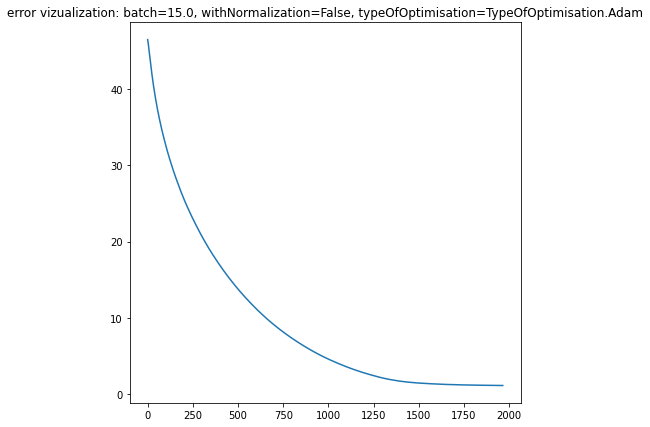

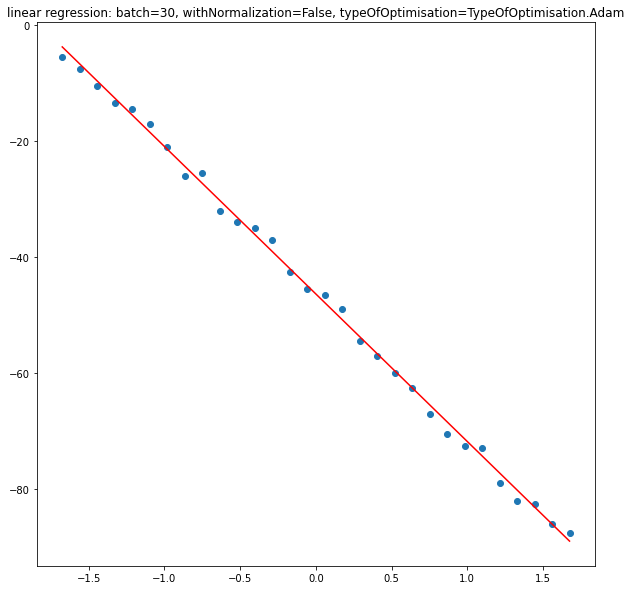

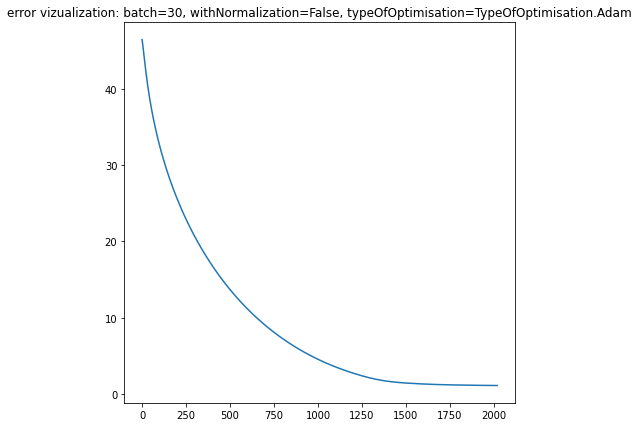

/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
/var/folders/jf/t98pfdyj3496cy7sfv395_j80000gn/T/ipykernel_13506/2880509699.py:33: RuntimeWarning: invalid value encountered in true_divide
  BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)


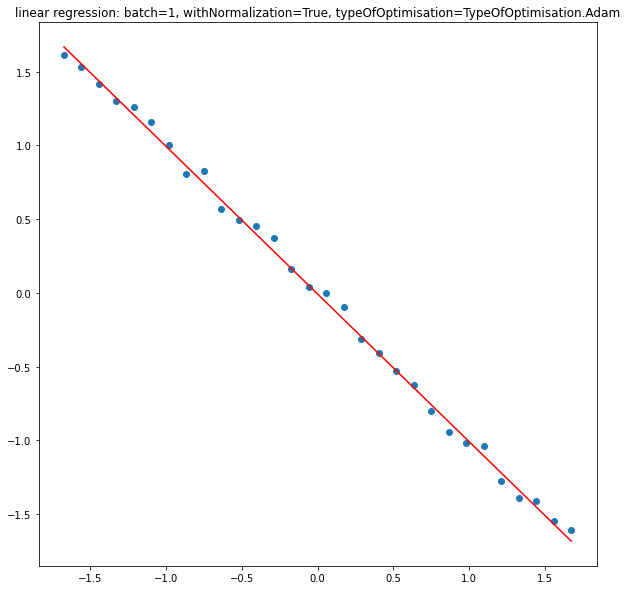

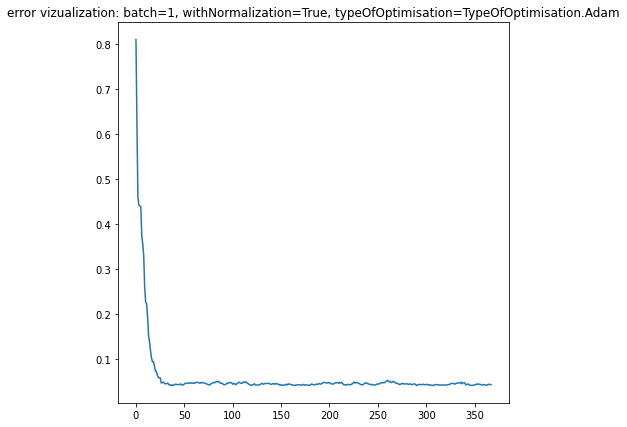

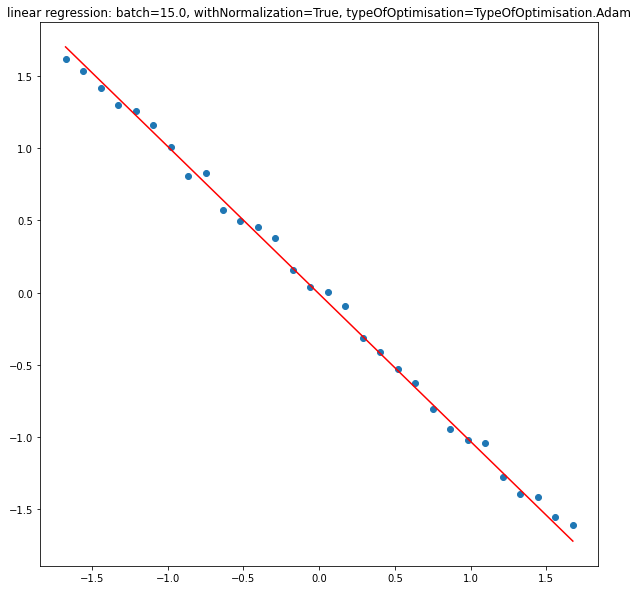

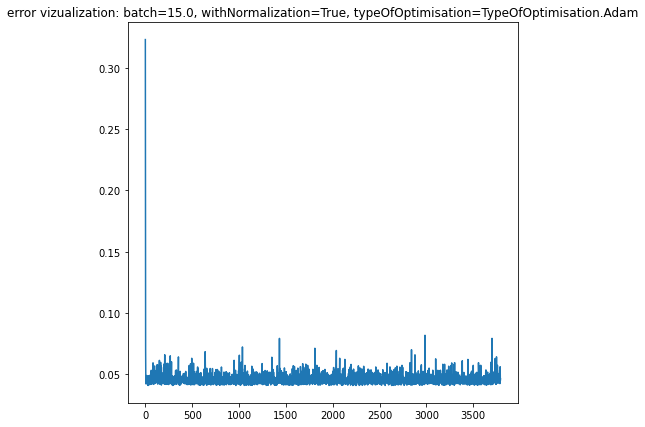

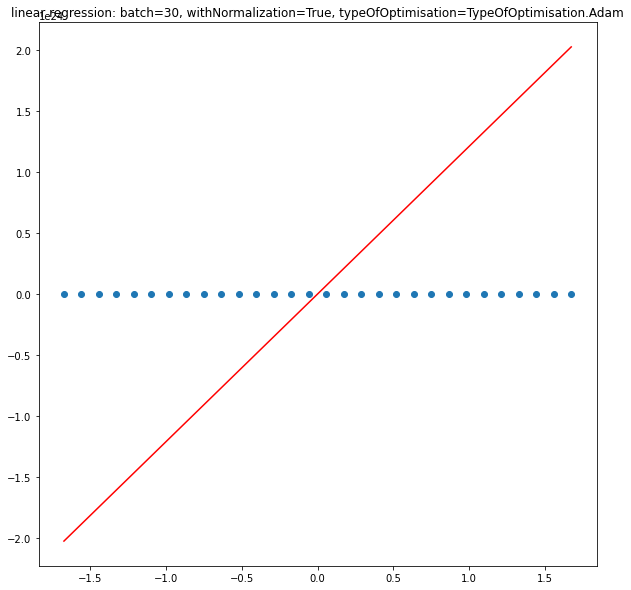

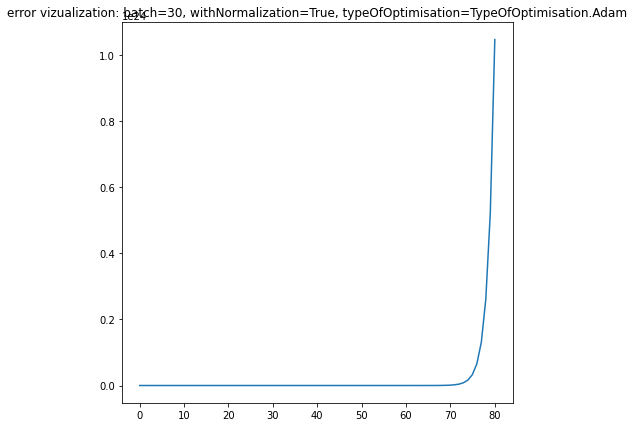

In [263]:
print("without normalization: ")
runSGD(1, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
runSGD(M, TypeOfOptimisation.Adam, withNormalization=False, lr=1e-1, eps=1e-4)
print("with normaliztion: ")
runSGD(1, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M / 2, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)
runSGD(M, TypeOfOptimisation.Adam, withNormalization=True, lr=1e-1, eps=1e-6)

